<a href="https://colab.research.google.com/github/AngeMervaneJdev/ML_AI_1/blob/main/Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.patches as mpatches
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.tree import plot_tree
from math import log2


#[Problem 1] Function for finding impureness

In [3]:
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [4]:
def gini_impurity(y):
  '''
  Given a Pandas Series, it calculates the Gini Impurity. 
  y: variable with which calculate Gini Impurity.
  '''
  if isinstance(y, pd.Series):
    p = y.value_counts()/y.shape[0]
    gini = 1-np.sum(p**2)
    return(gini)

  else:
    raise('Object must be a Pandas Series.')

#[Problem 2] Function for finding information gain

In [5]:
def entropy(y):
  '''
  Given a Pandas Series, it calculates the entropy. 
  y: variable with which calculate entropy.
  '''
  if isinstance(y, pd.Series):
    a = y.value_counts()/y.shape[0]
    entropy = np.sum(-a*np.log2(a+1e-9))
    return(entropy)

  else:
    raise('Object must be a Pandas Series.')

def variance(y):
  '''
  Function to help calculate the variance avoiding nan.
  y: variable to calculate variance to. It should be a Pandas Series.
  '''
  if(len(y) == 1):
    return 0
  else:
    return y.var()

def information_gain(y, mask, func=entropy):
  '''
  It returns the Information Gain of a variable given a loss function.
  y: target variable.
  mask: split choice.
  func: function to be used to calculate Information Gain in case os classification.
  '''
  a = sum(mask)
  b = mask.shape[0] - a
  
  if(a == 0 or b ==0): 
    ig = 0
  
  else:
    if y.dtypes != 'O':
      ig = variance(y) - (a/(a+b)* variance(y[mask])) - (b/(a+b)*variance(y[-mask]))
    else:
      ig = func(y)-a/(a+b)*func(y[mask])-b/(a+b)*func(y[-mask])
  
  return ig

#[Problem 3] Learning

In [6]:
import itertools

def categorical_options(a):
  '''
  Creates all possible combinations from a Pandas Series.
  a: Pandas Series from where to get all possible combinations. 
  '''
  a = a.unique()

  opciones = []
  for L in range(0, len(a)+1):
      for subset in itertools.combinations(a, L):
          subset = list(subset)
          opciones.append(subset)

  return opciones[1:-1]

def max_information_gain_split(x, y, func=entropy):
  '''
  Given a predictor & target variable, returns the best split, the error and the type of variable based on a selected cost function.
  x: predictor variable as Pandas Series.
  y: target variable as Pandas Series.
  func: function to be used to calculate the best split.
  '''

  split_value = []
  ig = [] 

  numeric_variable = True if x.dtypes != 'O' else False

  # Create options according to variable type
  if numeric_variable:
    options = x.sort_values().unique()[1:]
  else: 
    options = categorical_options(x)

  # Calculate ig for all values
  for val in options:
    mask =   x < val if numeric_variable else x.isin(val)
    val_ig = information_gain(y, mask, func)
    # Append results
    ig.append(val_ig)
    split_value.append(val)

  # Check if there are more than 1 results if not, return False
  if len(ig) == 0:
    return(None,None,None, False)

  else:
  # Get results with highest IG
    best_ig = max(ig)
    best_ig_index = ig.index(best_ig)
    best_split = split_value[best_ig_index]
    return(best_ig,best_split,numeric_variable, True)

#ScratchDecesionTreeClassifierDepth1()

In [65]:
class ScratchDecesionTreeClassifierDepth1():
    """
    Depth 1 decision tree classifier scratch implementation
    Parameters
    ----------
    verbose : bool
      True to output the learning process
    """
    def __init__(self, verbose=False, min_samples_split=2, max_depth=100, n_feats=None):
        # Record hyperparameters as attributes
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None
        self.verbose = verbose


    def fit(self, X, y):
        """
        Learn the decision tree classifier
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        """
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)
            
            
        if self.verbose:
          print()
        
    def predict(self, X):
        """
        Estimate the label using a decision tree classifier
        """
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        #stopping criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        #greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
        #grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        #parent loss
        parent_entropy = entropy(pd.Series(y))

        #generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        #compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(pd.Series(y[left_idxs])), entropy(pd.Series(y[right_idxs]))
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        #information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

#[Problem 7] (Advance assignment) Creation of a decision tree classifier class with a depth of 2

#[Problem 8] (Advance assignment) Creation of decision tree classifier class with unlimited depth

In [66]:
class Node:
   """Cette classe a pour but de représenter les branches de notre arbre de
   regression.
   """   
   def __init__(self, feature=None, threshold=None, left=None, right=None,nature='quanti', *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
       
   def __split__(self):
      if self.nature == 'quanti' :
          return self.feature + ' <= ' + str(self.value)
      elif self.nature == 'quali' :
          return self.feature + ' == ' + str(self.value)
   def is_leaf_node(self):
        return self.value is not None

In [ ]:
### train with iris data

In [67]:
data = load_iris()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.42, random_state=20)
model = ScratchDecesionTreeClassifierDepth1(verbose=True)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(y_pred)


[0 1 1 1 1 1 2 0 2 0 2 1 1 0 0 2 0 1 2 1 1 2 2 0 1 1 1 0 2 1 1 1 0 0 0 1 1
 0 1 2 1 1 0 1 1 0 0 0 2 0 2 2 0 2 1 1 1 0 0 1 1 1 1]


In [68]:
accuracy_score(y_test,y_pred)

0.9206349206349206

#Compare this with the scikit-learn implementation and see if it works correctly.



In [72]:
model1=DecisionTreeClassifier()
model1.fit(X_train,y_train)
y_pred1 = model1.predict(X_test)
print(y_pred1)

[0 1 1 1 1 1 2 0 2 0 2 1 1 0 0 2 0 1 2 1 1 2 2 0 1 1 1 0 2 1 1 1 0 0 0 1 1
 0 1 2 1 1 0 1 1 0 0 0 2 0 2 2 0 2 1 1 1 0 0 1 1 1 1]


In [70]:
accuracy_score(y_test,y_pred1)

0.9206349206349206

#### Les résultats sont les mêmes

#[Problem 6] Visualization of decision area

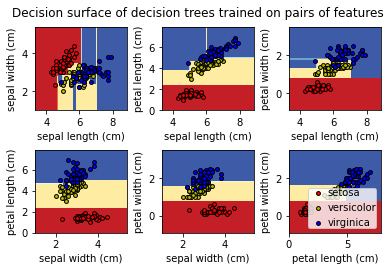

In [87]:

# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02


for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = data.data[:, pair]
    y = data.target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(data.feature_names[pair[0]])
    plt.ylabel(data.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=data.target_names[i],
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )

plt.suptitle("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
_ = plt.axis("tight")